In [1]:
#import the libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import time
import math
import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics


random_state = 42

In [2]:
#load the weighted average COI data

coi_district_grouped_data_df = pd.read_csv('data_raw/coi_district_grouped.csv')


In [3]:
#split the data into two subsets , one for 2010 and the other for 2015 data. One of the goals is to see
#how the school districts' oppurtunity index value changed between the years 2010 and 2015.
coi_district_grouped_2010_data_df = coi_district_grouped_data_df[coi_district_grouped_data_df['year'] == 2010]
coi_district_grouped_2015_data_df = coi_district_grouped_data_df[coi_district_grouped_data_df['year'] == 2015]


In [4]:
#extract the real values columns into a numpy array. The array will be used to feed into the dimensinality reduction
#and clustering methods later
feature_columns = ['pop_total', 'pop_child',
       'ED_APENR', 'ED_ATTAIN', 'ED_COLLEGE', 'ED_ECENROL', 'ED_HSGRAD',
       'ED_MATH', 'ED_READING', 'ED_SCHPOV', 'ED_TEACHXP', 'ED_PRXECE',
       'ED_PRXHQECE', 'HE_FOOD', 'HE_GREEN', 'HE_HEAT', 'HE_HLTHINS',
       'HE_OZONE', 'HE_PM25', 'HE_VACANCY', 'HE_WALK', 'HE_SUPRFND', 'HE_RSEI',
       'SE_POVRATE', 'SE_PUBLIC', 'SE_HOME', 'SE_OCC', 'SE_MHE', 'SE_EMPRAT',
       'SE_JOBPROX', 'SE_SINGLE']


X_2015_dataset = np.array(coi_district_grouped_2015_data_df[feature_columns])
#Scale the data

scaler_2015 = StandardScaler()

X_2015_scaled = scaler_2015.fit_transform(X_2015_dataset)

#this is how the data looks after scaling

X_2015_scaled

array([[-0.16944628, -0.15324915, -1.20088774, ..., -2.24075212,
        -1.03291525,  0.01936115],
       [-0.25111275, -0.25630656, -0.34079291, ..., -3.1750307 ,
        -1.13845032,  2.00380269],
       [ 0.04910132,  0.13828019,  0.61898784, ..., -0.55505656,
        -0.0722572 ,  0.49054952],
       ...,
       [-0.12750679, -0.15639419,  1.6283548 , ...,  1.75544102,
        -1.39216588, -0.35138717],
       [-0.28856449, -0.30436422, -0.2472472 , ..., -0.27866225,
         2.87316832,  0.29305125],
       [-0.24181476, -0.24863575, -0.10166364, ...,  0.21112223,
        -0.8248696 , -0.05760164]])

In [5]:
#now re-fit the pca on 11 components for 2010 data. We used the number of components from the Kmeans clustring notebook
pca_2015 = PCA(n_components = 11, random_state=random_state)
coi_district_grouped_data_tranformed_2015_array = pca_2015.fit_transform(X_2015_scaled)

In [6]:
#get the principal components in a single dataframe
#Combine/Concatenate the orignial COI data and the principal components together for 2010
pca_with_coi_district_grouped_data_df = pd.concat([coi_district_grouped_2015_data_df.reset_index(drop = True), pd.DataFrame(coi_district_grouped_data_tranformed_2015_array)],axis = 1)
pca_with_coi_district_grouped_data_df.columns.values[-11:] = ['Component 1','Component 2','Component 3','Component 4','Component 4','Component 6','Component 7','Component 8','Component 9','Component 10','Component 11']



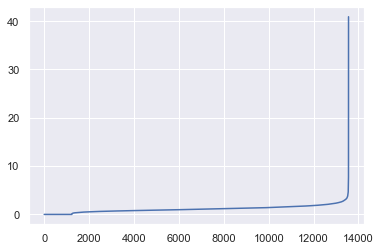

In [11]:
#heuristics to get the value of epsilon to input into DBScan
import numpy as np
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(coi_district_grouped_data_tranformed_2015_array)
distances, indices = nbrs.kneighbors(coi_district_grouped_data_tranformed_2015_array)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#This section below for DBSCAN


In [12]:
#fit the DBSCAN method with a  epsilon value of 2.0 to start with. We got the value 2 for epsilon from the above visual
db = DBSCAN(eps=2.0, min_samples=50).fit(coi_district_grouped_data_tranformed_2015_array )


In [13]:
db.n_features_in_
#set(db.labels_)
#len(db.components_)

11

In [14]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 1
Estimated number of noise points: 4475


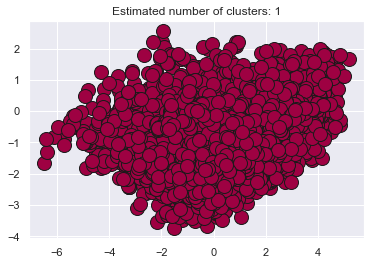

In [16]:
# Plot the code data.  Core data in DBSCAN method are those samples which are within epsilon distance from each other.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k
    xy_core = coi_district_grouped_data_tranformed_2015_array[class_member_mask & core_samples_mask]
    plt.plot(
        xy_core[:, 0],
        xy_core[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
#plot_core
plt.show()

In [17]:
#check the number of non-core/noisy points. As we see here, there are a lot of noise datapoints
coi_district_grouped_data_tranformed_2015_array.shape#[class_member_mask & core_samples_mask]

(13559, 11)

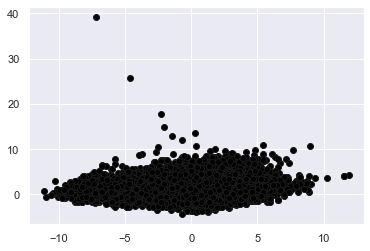

In [18]:
#plot the non-core  data   
xy_non_core = coi_district_grouped_data_tranformed_2015_array[class_member_mask & ~core_samples_mask]
plot_non_core  = plt.plot(
        xy_non_core[:, 0],
        xy_non_core[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
    